In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

%matplotlib inline

register_matplotlib_converters()
sns.set(style="darkgrid", font_scale=1.5)

LENGTH = 20
LOOK_AHEAD_LENGTH = 3

# Train Model

In [13]:
def preprocessTestingData(data, length, look_ahead_length):
    hist = []
    target = []

    for i in range(len(data)-length-look_ahead_length):
        x = data[i:i+length]
        y = data[i+length+look_ahead_length]
        hist.append(x)
        target.append(y)
    
    # Convert into numpy arrays and shape correctly (len(dataset), length) and (len(dataset), 1) respectivly
    hist = np.array(hist)
    target = np.array(target)
    target = target.reshape(-1,1)

    #Reshape the input into (len(dataset), length, 1)
    hist = hist.reshape((len(hist), length, 1))

    return(hist, target)

In [14]:
def trainModel(datasets, length, model=None, quiet=False):
    for dataset in datasets:
        X_train, y_train = preprocessTestingData(dataset, length, LOOK_AHEAD_LENGTH)

        if not model:
            # Create model and compile
            model = tf.keras.Sequential()
            model.add(layers.LSTM(units=32, return_sequences=True, input_shape=(length,1), dropout=0.2))
            model.add(layers.LSTM(units=32, return_sequences=True, dropout=0.2))
            model.add(layers.LSTM(units=32, dropout=0.2))
            model.add(layers.Dense(units=1))
            model.compile(optimizer='adam', loss='mean_squared_error')

        # Perform training
        output = 1
        if quiet:
            output = 0
        history = model.fit(X_train, y_train, epochs=100, batch_size=320, verbose=output)

        # Show loss
        if not quiet:
            loss = history.history['loss']
            epoch_count = range(1, len(loss) + 1)
            plt.figure(figsize=(6,4))
            plt.plot(epoch_count, loss, 'r--')
            plt.legend(['Training Loss'])
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()

    return model

In [15]:
def scaleData(paths):
    scaler = MinMaxScaler()
    datasets = []
    for path in paths:
        # perform partial fits on all datasets
        my_frame = pd.read_csv(path)[['price']].diff()[1::].reset_index(drop=True)
        np.array(my_frame)
        datasets.append(np.array(my_frame))
        # scaler = scaler.partial_fit(datasets[-1])
    # for i in range(len(datasets)):
        # once all partial fits have been performed, transform every file
        # datasets[i] = scaler.transform(datasets[i])
    return (datasets, scaler)


Epoch 1/100
345/345 [==============================] - 6s 11ms/step - loss: 23.4002
Epoch 2/100
345/345 [==============================] - 4s 10ms/step - loss: 23.6787
Epoch 3/100
345/345 [==============================] - 4s 10ms/step - loss: 23.6119
Epoch 4/100
345/345 [==============================] - 4s 10ms/step - loss: 23.5889
Epoch 5/100
345/345 [==============================] - 4s 10ms/step - loss: 23.1509
Epoch 6/100
345/345 [==============================] - 4s 10ms/step - loss: 23.0698
Epoch 7/100
345/345 [==============================] - 4s 10ms/step - loss: 22.9031
Epoch 8/100
345/345 [==============================] - 4s 10ms/step - loss: 23.1985
Epoch 9/100
345/345 [==============================] - 4s 10ms/step - loss: 23.6557
Epoch 10/100
345/345 [==============================] - 3s 10ms/step - loss: 22.9247
Epoch 11/100
345/345 [==============================] - 4s 10ms/step - loss: 23.3101
Epoch 12/100
345/345 [==============================] - 3s 10ms/step - los

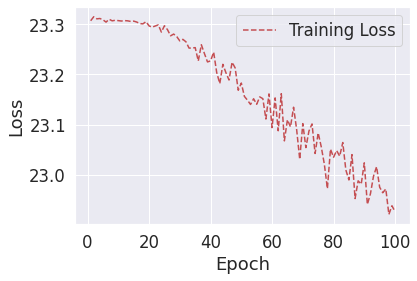

In [16]:
paths = ["../../data/dump.csv"]

datasets, scaler = scaleData(paths)

model = trainModel(datasets, LENGTH)

# Test Model
## Evaluation Helpers

In [17]:
def evaluate_model(real_data, predicted_data, inherent_loss):
    real_data = real_data.reshape(len(real_data))
    predicted_data = predicted_data.reshape(len(predicted_data))

    real_diff = real_data
    predicted_diff = predicted_data

    correct_slopes = 0
    percent_error = 0
    profit = 0
    for i in range(len(real_data)-1-LOOK_AHEAD_LENGTH):
        if real_diff[i]:
            percent_error += (predicted_diff[i] - real_diff[i]) / real_diff[i]
        if np.sign(real_diff[i+LOOK_AHEAD_LENGTH-1]) == np.sign(predicted_diff[i]):
            correct_slopes = correct_slopes + 1
            
            # If we have a positive slope calculate profit
            if predicted_diff[i] > 0.75:
                # we subtract inherent_loss due to the limit market mechanics
                revenue = (real_data[i+1] - real_data[i]) - inherent_loss
                if revenue > 0:
                    # print(f"Found a profit where current value is {real_data[i+1]} last was {real_data[i]} net {revenue}")
                    profit = profit + revenue

        else:
            # We guessed wrong
            if predicted_diff[i] > 0:
                # we would have bought
                revenue = (real_data[i+1] - real_data[i]) - inherent_loss
                # print(f"Selling at a loss of {revenue}")
                profit = profit + revenue

    return (correct_slopes, profit, percent_error/(len(real_data)-1-LOOK_AHEAD_LENGTH))


In [18]:
def eval_model_on_dataset(actual, prediction, inherent_loss):
    # Determine the number of cases in which we predicted a correct increase
    correct_slopes, profit, percent_error = evaluate_model(actual, prediction, inherent_loss)

    print(f"Found {correct_slopes} out of {len(actual)-1}")
    precent_success = (correct_slopes/(len(actual)-1)) * 100
    print(f"{precent_success}%")
    print("Profit:", profit)
    print("Percent error: ", percent_error)
    return profit

## Test Model

In [27]:
def testModel(model, path_to_testing_dataset, quiet=False):

    datasets, scaler = scaleData([path_to_testing_dataset])

    hist, actual = preprocessTestingData(datasets[0], LENGTH, LOOK_AHEAD_LENGTH)

    pred = model.predict(hist)

    pred_transformed = pred#scaler.inverse_transform(pred)
    actual_transformed = actual[3::]

    if not quiet:
        plt.figure(figsize=(48,8))
        plt.plot(actual_transformed, color='blue', label='Real')
        plt.plot(pred_transformed, color='red', label='Prediction')
        plt.title('ETH Price Prediction')
        plt.legend()
        plt.show()

    return eval_model_on_dataset(actual=actual_transformed, prediction=pred_transformed, inherent_loss=1.5)


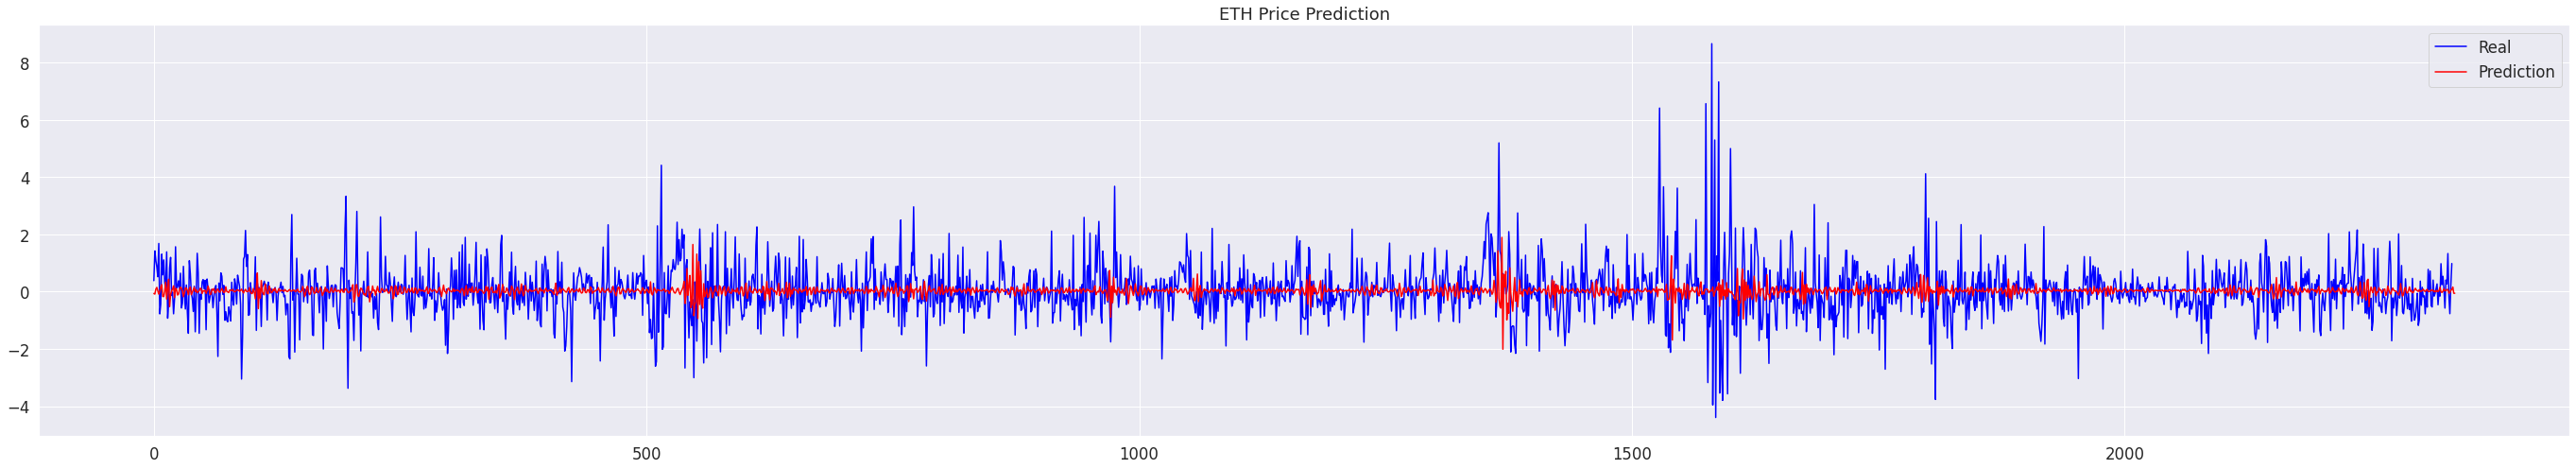

Found 1129 out of 2332
48.41337907375643%
Profit: -1211.9564040000018
Percent error:  -0.916110826617091


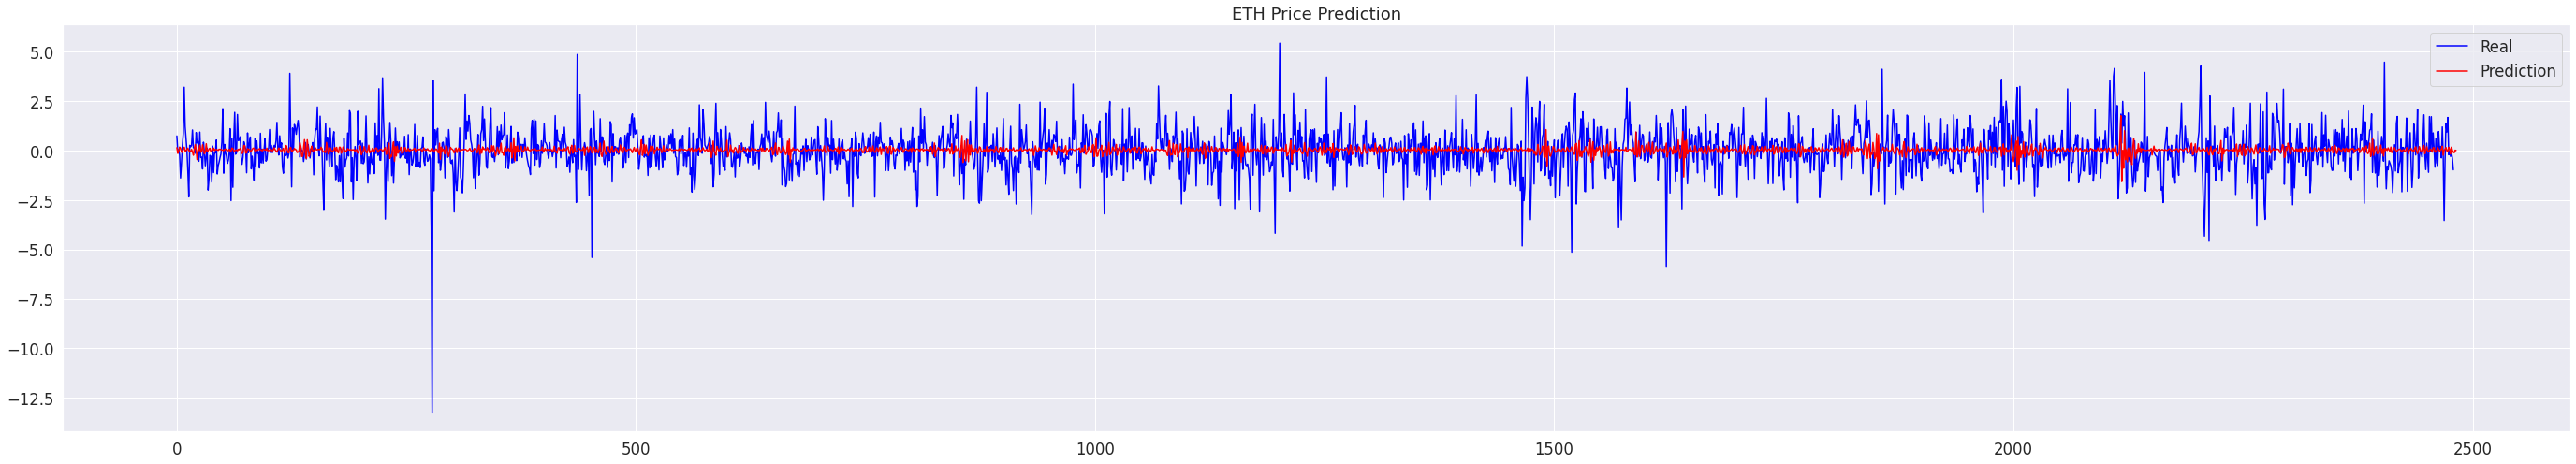

Found 1241 out of 2479
50.06050826946349%
Profit: -1125.1088960000018
Percent error:  -1.0621903006351505


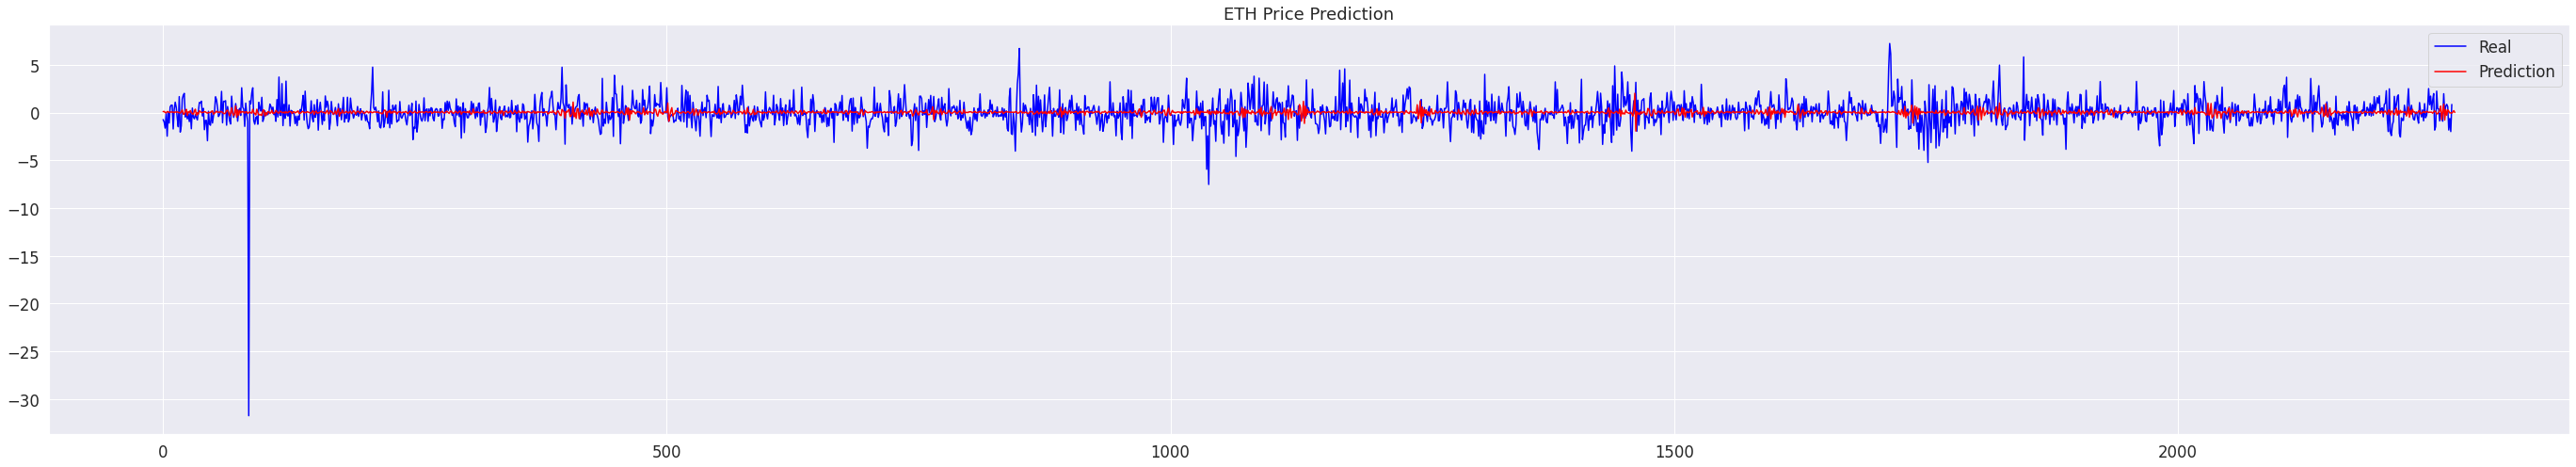

Found 1104 out of 2272
48.59154929577465%
Profit: -1034.6285489999998
Percent error:  -0.909919984199


-1034.6285489999998

In [28]:
testModel(model, "../data/test_data/test6.csv")
testModel(model, "../data/test_data/test8.csv")
testModel(model, "../data/test_data/test10.csv")